<a href="https://colab.research.google.com/github/bhartikapoor9634/Computer_Vision_Projects/blob/main/grapevine_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [ ]:
import os
import numpy as np 
import pandas as pd

from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.imagenet_utils import preprocess_input

from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split

import cv2

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']="/content/"

!kaggle datasets download muratkokludataset/grapevine-leaves-image-dataset



 91% 99.0M/109M [00:01<00:00, 110MB/s] 
100% 109M/109M [00:01<00:00, 88.4MB/s]


In [ ]:
import zipfile
! unzip "grapevine-leaves-image-dataset.zip" 

Archive:  grapevine-leaves-image-dataset.zip
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (1).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (10).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (100).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (11).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (12).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (13).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (14).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (15).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (16).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (17).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (18).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (19).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (2).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (20).png  
  inflating: Grapevine_Leaves_Image_Dataset/Ak/Ak (21).png  
  inflating: Grapevine_Leaves_Image_Datas

# DATA PROCESSING 

In [ ]:
cats = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
dir = '/content/Grapevine_Leaves_Image_Dataset'

print(os.listdir(dir))


['Buzgulu', 'Ak', 'Grapevine_Leaves_Image_Dataset_Citation_Request.txt', 'Ala_Idris', 'Nazli', 'Dimnit']


In [ ]:
img_path = []
classes = []

for d in os.listdir(dir):
    lbl_path = os.path.join(dir,d)
    if d in cats:
        for image in os.listdir(lbl_path):
            img_path.append(os.path.join(lbl_path, image))
            classes.append(d)

In [ ]:
img_path = pd.Series(img_path)
classes = pd.Series(classes)

img_data = pd.DataFrame({'Path':img_path.values, 'Label':classes.values})


In [ ]:
img_data.head()

,Path,Label
0,/content/Grapevine_Leaves_Image_Dataset/Buzgul...,Buzgulu
1,/content/Grapevine_Leaves_Image_Dataset/Buzgul...,Buzgulu
2,/content/Grapevine_Leaves_Image_Dataset/Buzgul...,Buzgulu
3,/content/Grapevine_Leaves_Image_Dataset/Buzgul...,Buzgulu
4,/content/Grapevine_Leaves_Image_Dataset/Buzgul...,Buzgulu


In [ ]:
img_data = img_data.sample(frac=1, axis=0).reset_index(drop=True)


X_train, X_val, y_train, y_val = train_test_split(img_data[['Path', 'Label']], img_data[['Label']], test_size=0.25, random_state=42)
X_val

,Path,Label
361,/content/Grapevine_Leaves_Image_Dataset/Ala_Id...,Ala_Idris
73,/content/Grapevine_Leaves_Image_Dataset/Dimnit...,Dimnit
374,/content/Grapevine_Leaves_Image_Dataset/Nazli/...,Nazli
155,/content/Grapevine_Leaves_Image_Dataset/Nazli/...,Nazli
104,/content/Grapevine_Leaves_Image_Dataset/Ala_Id...,Ala_Idris
...,...,...
220,/content/Grapevine_Leaves_Image_Dataset/Dimnit...,Dimnit
176,/content/Grapevine_Leaves_Image_Dataset/Dimnit...,Dimnit
320,/content/Grapevine_Leaves_Image_Dataset/Ala_Id...,Ala_Idris
153,/content/Grapevine_Leaves_Image_Dataset/Buzgul...,Buzgulu


# AUGMENTATORS

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        )

val_datagen = ImageDataGenerator(rescale=1 / 255.0)


In [ ]:
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col="Path",
    y_col="Label",
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col="Path",
    y_col="Label",
    target_size=(300, 300),
    batch_size=8,
    shuffle=False,
)

Found 375 validated image filenames belonging to 5 classes.
Found 125 validated image filenames belonging to 5 classes.


# CUSTOM MODEL

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(300, 300, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64,kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128,kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256,kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(GlobalAveragePooling2D())

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation='relu'))

cnn_model.add(Dense(5, activation='softmax'))



cnn_model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])

cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 296, 296, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 144, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 68, 68, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 34, 128)      0

In [ ]:
cnn_history=cnn_model.fit(train_generator,
        steps_per_epoch = 8,
        validation_data= validation_generator,
        epochs=10)

Epoch 1/10
8/8 [==============================] - 137s 17s/step - loss: 1.6173 - accuracy: 0.1781 - val_loss: 1.6104 - val_accuracy: 0.1760
Epoch 2/10
8/8 [==============================] - 131s 16s/step - loss: 1.6109 - accuracy: 0.2105 - val_loss: 1.6244 - val_accuracy: 0.1760
Epoch 3/10
8/8 [==============================] - 132s 16s/step - loss: 1.6089 - accuracy: 0.2146 - val_loss: 1.6208 - val_accuracy: 0.1760
Epoch 4/10
8/8 [==============================] - 130s 16s/step - loss: 1.6041 - accuracy: 0.1943 - val_loss: 1.6479 - val_accuracy: 0.1760
Epoch 5/10
8/8 [==============================] - 129s 16s/step - loss: 1.6113 - accuracy: 0.2105 - val_loss: 1.6210 - val_accuracy: 0.1840
Epoch 6/10
8/8 [==============================] - 128s 16s/step - loss: 1.6106 - accuracy: 0.2024 - val_loss: 1.6121 - val_accuracy: 0.1760
Epoch 7/10
8/8 [==============================] - 132s 16s/step - loss: 1.6078 - accuracy: 0.2470 - val_loss: 1.6134 - val_accuracy: 0.1760
Epoch 8/10
8/8 [====

The custom model performs very poorly and achieves only an accuracy of around 0.2 

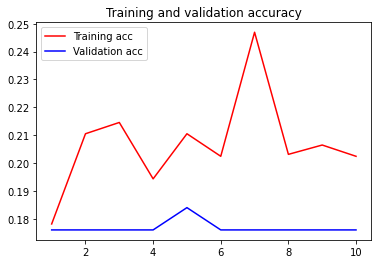

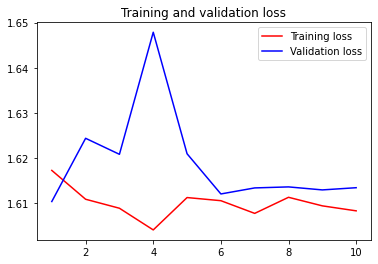

In [ ]:
import matplotlib.pyplot as plt
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# INCEPTION MODEL

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in inception.layers[:-15]:
    layer.trainable = False

inception_model = Sequential([
        inception,
        GlobalAveragePooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

inception_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               

In [ ]:
inception_model.compile(
        optimizer= 'adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"])

In [ ]:
inception_history = inception_model.fit(train_generator, 
                    steps_per_epoch = 8, 
                    validation_data = validation_generator,
                    validation_steps = 2,
                    epochs = 10)

Epoch 1/10
8/8 [==============================] - 71s 8s/step - loss: 1.6691 - accuracy: 0.2955 - val_loss: 1.5396 - val_accuracy: 0.3125
Epoch 2/10
8/8 [==============================] - 86s 11s/step - loss: 1.2600 - accuracy: 0.4737 - val_loss: 1.4604 - val_accuracy: 0.3125
Epoch 3/10
8/8 [==============================] - 101s 12s/step - loss: 1.0394 - accuracy: 0.5911 - val_loss: 1.4169 - val_accuracy: 0.4375
Epoch 4/10
8/8 [==============================] - 72s 9s/step - loss: 0.8949 - accuracy: 0.6073 - val_loss: 1.4944 - val_accuracy: 0.4375
Epoch 5/10
8/8 [==============================] - 89s 11s/step - loss: 0.8733 - accuracy: 0.6445 - val_loss: 1.2845 - val_accuracy: 0.6875
Epoch 6/10
8/8 [==============================] - 90s 11s/step - loss: 0.7571 - accuracy: 0.7206 - val_loss: 1.2926 - val_accuracy: 0.6250
Epoch 7/10
8/8 [==============================] - 77s 9s/step - loss: 0.6510 - accuracy: 0.8057 - val_loss: 1.2157 - val_accuracy: 0.7500
Epoch 8/10
8/8 [=============

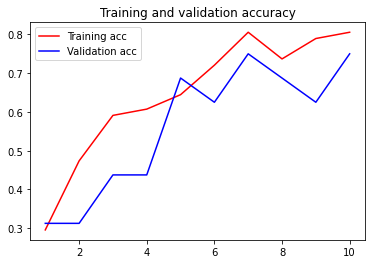

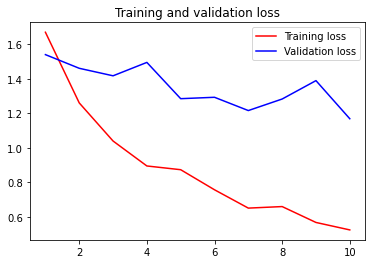

In [ ]:
acc = inception_history.history['accuracy']
val_acc = inception_history.history['val_accuracy']
loss = inception_history.history['loss']
val_loss = inception_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# VGG MODEL

In [ ]:
vgg19 = VGG19(include_top = False, input_shape = (300,300,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in vgg19.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


In [ ]:
history_vgg = model_vgg.fit(
      train_generator,
      validation_data=validation_generator,
      steps_per_epoch = 8, 
      epochs=10)

Epoch 1/10
8/8 [==============================] - 444s 58s/step - loss: 1.6699 - accuracy: 0.2109 - val_loss: 1.6402 - val_accuracy: 0.1680
Epoch 2/10
8/8 [==============================] - 441s 57s/step - loss: 1.6077 - accuracy: 0.2031 - val_loss: 1.6231 - val_accuracy: 0.2160
Epoch 3/10
8/8 [==============================] - 429s 56s/step - loss: 1.5959 - accuracy: 0.2267 - val_loss: 1.6042 - val_accuracy: 0.1840
Epoch 4/10
8/8 [==============================] - 438s 57s/step - loss: 1.5772 - accuracy: 0.2930 - val_loss: 1.5984 - val_accuracy: 0.2480
Epoch 5/10
8/8 [==============================] - 427s 56s/step - loss: 1.5667 - accuracy: 0.3279 - val_loss: 1.5882 - val_accuracy: 0.3200
Epoch 6/10
8/8 [==============================] - 437s 57s/step - loss: 1.5500 - accuracy: 0.3887 - val_loss: 1.5799 - val_accuracy: 0.2720
Epoch 7/10
8/8 [==============================] - 431s 56s/step - loss: 1.5274 - accuracy: 0.4008 - val_loss: 1.5846 - val_accuracy: 0.3200
Epoch 8/10
8/8 [====

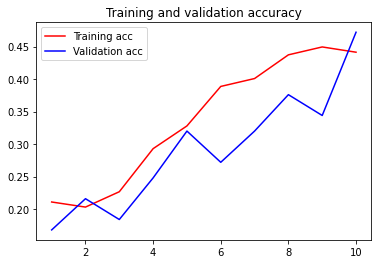

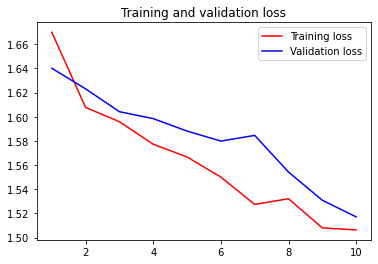

In [ ]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The inception model performs very well for both the training and validation set with accuracy >0.9 